# DONE:

- x include non-Metaphor data and label

# TODO:

- repeat experiments after sampling original sentences, not random sampling
    - at the moment we just memorize which sentence has a metaphor.
    - This is not representative of the actual performance
    
- include F1-score in evaluation

- test F1-score loss function

- make use of cuda or mps nicer

- Try freezing some layers. Hopefully reduces training time (significantly)
    - https://github.com/huggingface/transformers/issues/400
    - https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088
    
- fix the damn indentation on the accuracy

In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
import re

np.random.seed(3093453)
sns.set(context="talk", style="darkgrid")

In [2]:
cwd = os.getcwd()
folder = "clean+translated-data"
file = "clean-de.csv"
path = "/".join( (cwd, folder, file) )

df = pd.read_csv(path, index_col=0)
df["lang"] = "de"

files = os.listdir(folder)
files = [file for file in files if re.match(r'clean-[a-z]{2}-de.csv', file)]

for file in files:
    path = "/".join( (cwd, folder, file) )
    data = pd.read_csv(path, index_col=0)
    data["lang"] = file[6:8]
    
    df = pd.concat([df, data])

del(data)
df.reset_index(inplace=True)
df

,index,Textstelle,Metapher,Kandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig,lang
0,0,Der politische Körper verwendet in beiden Fäll...,3,1,0,Metapher,"['Zähnen und Krallen', 'Zähnen und Krallen', n...","['der politische Körper', 'der politische Körp...","['B', 'K', 'A', 'GoldStandard']","""Der politische Körper verwendet in beiden Fä...",de
1,1,Immer noch wird durch die protestantische Lehr...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Immer noch wird durch die protestantische Le...",de
2,2,"Kein Zweifel, schreibt Alb. Schaeffle, vorauss...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Kein Zweifel"", schreibt Alb. Schaeffle 1), v...",de
3,3,Mit je weiterem Blick wir die Stoffwelt zu übe...,1,3,0,Metaphernkandidat,"[nan, 'Stoffwelt, verzwergt und entkleidet', n...","[nan, 'unser praktisches Ideal', nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Mit je weiterem Blick wir die Stoffwelt zu ü...",de
4,4,Solange das Menschengeschlecht seinen Zerstöre...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Solange das Menschengeschlecht seinen Zerstö...",de
...,...,...,...,...,...,...,...,...,...,...,...
3990,794,Sie hat durchweg Naturwissenschaft in dem von ...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['T', 'P', 'B', 'GoldStandard']",verlaufs; sie hat Naturforschung in dem von un...,da
3991,795,Wenn wir uns ein Prinzip ausdenken und darauf ...,1,3,0,Metaphernkandidat,"[nan, nan, 'verstellbare Puppen', nan]","[nan, nan, 'staatliche Menschenverhältnisse', ...","['P', 'K', 'B', 'GoldStandard']",wenn wir uns ein Prinzip denken und auf Grund ...,da
3992,796,sieht man von dem Schimpfwort Rechtsphilosophi...,3,1,0,Metapher,"['schwindsüchtig ist', nan, 'schwindsüchtig', ...","['daß eine Philosophie', nan, 'eine Philosophi...","['P', 'K', 'B', 'GoldStandard']",wenn wir von dem schlechten Worte »Rechtsphilo...,da
3993,797,"Die Macht der Regierung, die verschiedenen Mot...",0,2,0,NaN,"[nan, nan]","[nan, nan]","['P', 'B']","»Die Macht, die das Kabinett hat, auf die vers...",da


In [3]:
cwd = os.getcwd()
folder = "clean+translated-data"
file = "non-metaphor-clean-de.csv"
path = "/".join( (cwd, folder, file) )

non = pd.read_csv(path)
non["lang"] = "de"
non

,index,Textstelle,Metapher,Kandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig,lang
0,0,Eine sammlung von preisscliristenz Herausgegeb...,0,0,1,Nein,NaN,NaN,X,Eine sammlung von preisscliristenz Herausgegeb...,de
1,1,Januar veröffentlichten die Professoren Haeck...,0,0,1,Nein,NaN,NaN,X,Januar 1900 veröffentlichten die Professoren H...,de
2,2,"Unter den Abhandlungen und Schriften, welche ...",0,0,1,Nein,NaN,NaN,X,"Unter den 60 Abhandlungen und Schriften, welch...",de
3,3,In dem vorliegenden Sammelwerke werden sieben ...,0,0,1,Nein,NaN,NaN,X,In dem vorliegenden Sammelwerke werden sieben ...,de
4,4,"Es folgt hier zunächst das Preisausschreiben, ...",0,0,1,Nein,NaN,NaN,X,"Es folgt hier zunächst das Preisausschreiben, ...",de
...,...,...,...,...,...,...,...,...,...,...,...
3960,3960,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...,de
3961,3961,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...,de
3962,3962,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...,de
3963,3963,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...,de


In [4]:
df = pd.concat([df, non])
df.reset_index(drop=True)
df.rename(columns= {"Kandidat": "Metaphernkandidat"}, inplace=True)
df

,index,Textstelle,Metapher,Metaphernkandidat,Nein,Metapher?,Fokus,Rahmen,Annotator,orig,lang
0,0,Der politische Körper verwendet in beiden Fäll...,3,1,0,Metapher,"['Zähnen und Krallen', 'Zähnen und Krallen', n...","['der politische Körper', 'der politische Körp...","['B', 'K', 'A', 'GoldStandard']","""Der politische Körper verwendet in beiden Fä...",de
1,1,Immer noch wird durch die protestantische Lehr...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Immer noch wird durch die protestantische Le...",de
2,2,"Kein Zweifel, schreibt Alb. Schaeffle, vorauss...",0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Kein Zweifel"", schreibt Alb. Schaeffle 1), v...",de
3,3,Mit je weiterem Blick wir die Stoffwelt zu übe...,1,3,0,Metaphernkandidat,"[nan, 'Stoffwelt, verzwergt und entkleidet', n...","[nan, 'unser praktisches Ideal', nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Mit je weiterem Blick wir die Stoffwelt zu ü...",de
4,4,Solange das Menschengeschlecht seinen Zerstöre...,0,4,0,Metaphernkandidat,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","['B', 'K', 'A', 'GoldStandard']","""Solange das Menschengeschlecht seinen Zerstö...",de
...,...,...,...,...,...,...,...,...,...,...,...
3960,3960,In der Zeit des Humanismus und der Reformation...,0,0,1,Nein,NaN,NaN,X,In der Zeit des Humanismus und der Reformation...,de
3961,3961,Den Mittelpunkt der Bildung stellten die alten...,0,0,1,Nein,NaN,NaN,X,Den Mittelpunkt der Bildung stellten die alten...,de
3962,3962,Jahrhunderts hat eine beständige Differenzieru...,0,0,1,Nein,NaN,NaN,X,Jahrhunderts hat eine beständige Differenzieru...,de
3963,3963,Die Pädagogik der Neuzeit scheint davon wenig ...,0,0,1,Nein,NaN,NaN,X,Die Pädagogik der Neuzeit scheint davon wenig ...,de


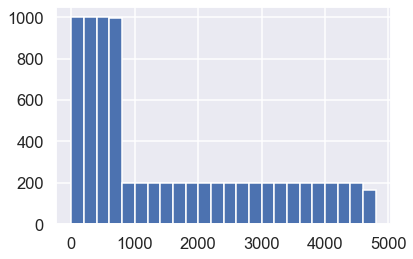

In [5]:
# create a original-sentence id
# We need to do this to make sure we dont have a german sentence in the train data
# ... and a english version in the test data, which skewes the results
# (Essentially the model would just memorize seen points, rather than learn what a metaphor is)

unique_sentences = df.orig.unique()

sentence_id = [np.where(sentence == unique_sentences)[0].item() for sentence in df.orig]
df["sentence_id"] = sentence_id
df["sentence_id"].hist(bins=np.arange(0, 5000, 200));

In [6]:
labs = ["Metapher", "Metaphernkandidat", "Nein"]

labels = dict(zip(range(3), labs))
labels

{0: 'Metapher', 1: 'Metaphernkandidat', 2: 'Nein'}

In [7]:
missing_lab = df["Metapher?"].isnull()
df.loc[missing_lab, "Metapher?"] = [labels[i] for i in df.loc[missing_lab, labs].to_numpy().argmax(axis=1)]

In [8]:
df.isnull().sum()

index                   0
Textstelle              0
Metapher                0
Metaphernkandidat       0
Nein                    0
Metapher?               0
Fokus                3965
Rahmen               3965
Annotator               0
orig                    0
lang                    0
sentence_id             0
dtype: int64

# BERT CLASSIFIER

https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

## DATASET

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Later: non-Metaphor: 0, Candidate: 1, Metaphor: 2
labs = ["Metapher", "Metaphernkandidat", "Nein"]

labels = dict(zip(labs, range(3)))
labels
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        # gold and silver labels
        
        self.labels = [labels[label] for label in df["Metapher?"]]
        self.labels = df[labs].to_numpy().argmax(axis=1)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Textstelle']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Train test split:

create a original-sentence id

We need to do this to make sure we dont have a german sentence in the train data and a english version in the test 
data, which skewes the results

(Essentially the model would just memorize seen points, rather than learn what a metaphor is)

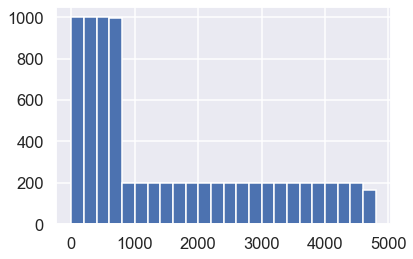

In [10]:
unique_sentences = df.orig.unique()

sentence_id = [np.where(sentence == unique_sentences)[0].item() for sentence in df.orig]
df["sentence_id"] = sentence_id
df["sentence_id"].hist(bins=np.arange(0, 5000, 200));

In [11]:
unique_sentence_ids = df.sentence_id.unique()

n_unique_sentences = len(unique_sentence_ids)

unique_sentence_ids

# randomize data before splitting
sample = np.random.choice(unique_sentence_ids, n_unique_sentences, replace=False)

In [12]:
#array([4552, 3661, 1351, ..., 2772, 4218, 2059])
# nice, sample is replicable
sample

array([4552, 3661, 1351, ..., 2772, 4218, 2059])

In [13]:
train_sentence_ids,val_sentence_ids,test_sentence_ids = np.split(sample,
                                                                 [int(.8*n_unique_sentences),
                                                                  int(.9*n_unique_sentences)])

print(len(train_sentence_ids),len(val_sentence_ids), len(test_sentence_ids))

3811 476 477


In [14]:
df_train = df[np.isin(df.sentence_id, train_sentence_ids)]

df_val   = df[np.isin(df.sentence_id, val_sentence_ids  )]

df_test  = df[np.isin(df.sentence_id, test_sentence_ids )]

print(len(df_train),len(df_val), len(df_test))

6411 804 745


In [15]:
pd.Series([labels[label] for label in df_train["Metapher?"]]).value_counts()

2    3161
1    2650
0     600
dtype: int64

## Building a Bert Model

In [16]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.softmax(linear_output)

        return final_layer

In [17]:
from torch.optim import Adam
from tqdm.notebook import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
        
        model = model.cuda()
        criterion = criterion.cuda()
        print("Using Graphics Card")
            
    if torch.backends.mps.is_available():
        model = model.to("mps")
        criterion = criterion.to("mps")
        print("Using M1 Chip!")
        
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} \n\
                | Train Loss: {total_loss_train / len(train_data): .3f} \t\
                | Train Accuracy: {total_acc_train / len(train_data): .3f}\n\
                | Val Loss: {total_loss_val / len(val_data): .3f} \t\
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at redewiedergabe/bert-base-historical-german-rw-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using M1 Chip!


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.126                 | Train Accuracy:  0.506
                 | Val Loss:  0.502                 | Val Accuracy:  0.519


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 2 | Train Loss:  0.120                 | Train Accuracy:  0.578
                 | Val Loss:  0.482                 | Val Accuracy:  0.558


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 3 | Train Loss:  0.110                 | Train Accuracy:  0.681
                 | Val Loss:  0.466                 | Val Accuracy:  0.602


  0%|          | 0/802 [00:00<?, ?it/s]

Epochs: 4 | Train Loss:  0.101                 | Train Accuracy:  0.749
                 | Val Loss:  0.463                 | Val Accuracy:  0.608


  0%|          | 0/802 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        model = model.to("mps")
        print("MPS available")

    if use_cuda:
        model = model.cuda()
    

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)
            
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

MPS available
Test Accuracy:  0.678


# Error analysis

In [76]:
test = Dataset(df_test)

batch_size=5

test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS available")

y_test_prob = np.empty((len(df_test), 3), float)

test_labels = np.zeros((len(df_test)), int)

with torch.no_grad():
    
        i = 0
        for test_input, test_label in test_dataloader:
            
            test_label = test_label.to(device)
            test_labels[i*batch_size:(i+1)*batch_size] = test_label.cpu()
            
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            y_test_prob[i*batch_size:(i+1)*batch_size] = model(input_id, mask).cpu()
            
            i+=1

MPS available


In [77]:
y_test_true = np.zeros((len(df_test), 3))
y_test_true[np.arange(len(df_test)),test_labels] = 1
y_test_true

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [78]:
y_test_prob

array([[0.01074233, 0.03250532, 0.9567523 ],
       [0.00510044, 0.28732193, 0.70757765],
       [0.00724424, 0.45606154, 0.53669417],
       ...,
       [0.01764642, 0.27950791, 0.70284563],
       [0.0069454 , 0.24936113, 0.74369347],
       [0.0058325 , 0.79648852, 0.19767904]])

In [96]:
test_preds = y_test_prob.argmax(axis=1)
y_test_pred = np.zeros((len(df_test), 3))
y_test_pred[np.arange(len(df_test)),test_preds] = 1
y_test_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

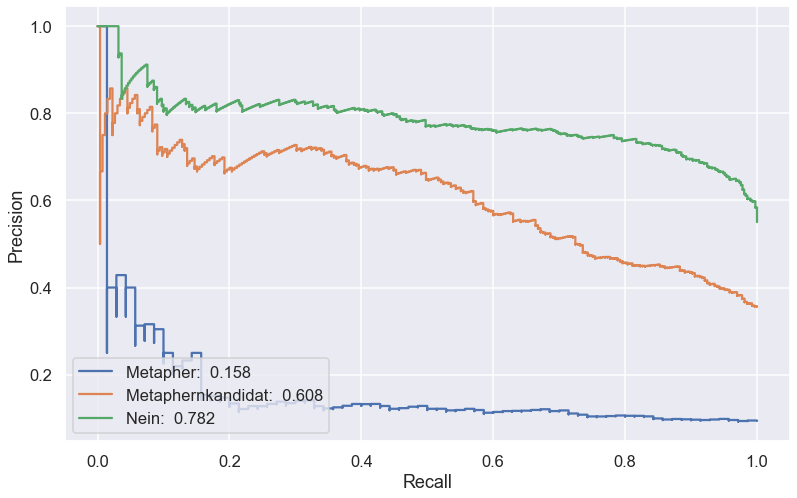

In [95]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

fig, ax = plt.subplots(figsize=(13, 8))
for i in range(3):
    prec, recall, _ = precision_recall_curve(y_test_true[:,i], y_test_prob[:,i])
    avg_prec = average_precision_score(y_test_true[:,i], y_test_prob[:,i])
    label = f"{labs[i]}:  {avg_prec:.3f}"
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax,label=label)

In [119]:
confusion_matrix = pd.crosstab(y_test_true.argmax(axis=1), y_test_prob.argmax(axis=1))
confusion_matrix.index = labs
confusion_matrix.index.name = "true label"
confusion_matrix

col_0,1,2
true label,,
Metapher,42,28
Metaphernkandidat,151,114
Nein,50,360


In [140]:
from sklearn.metrics import f1_score

print("F1 scores:\n"+"-"*23)
for i, lab in enumerate(labs):
    f1 = f1_score(y_test_true[:,i], y_test_pred[:,i], average = "binary")
    print(f"{lab:>17}: {f1:.2f}")

F1 scores:
-----------------------
         Metapher: 0.00
Metaphernkandidat: 0.59
             Nein: 0.79
